<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E1-SentimentPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1

## Analyze how travelers expressed their feelings on Twitter

A sentiment analysis job about the problems of each major U.S. airline.
Twitter data was scraped from February of 2015 and contributors were
asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# read the data and set the datetime as the index
tweets = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/Tweets.zip', index_col=0)

tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [2]:
tweets.shape

(14640, 14)

### Proportion of tweets with each sentiment

In [3]:
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

### Proportion of tweets per airline


In [4]:
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

<Axes: xlabel='airline'>

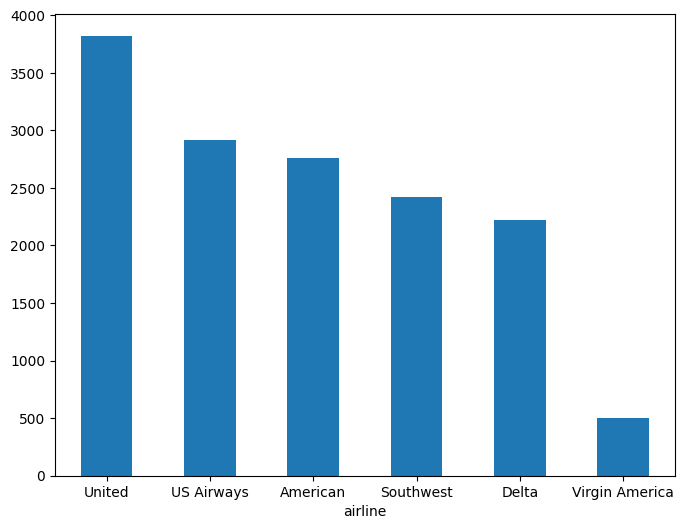

In [5]:
pd.Series(tweets["airline"]).value_counts().plot(kind = "bar",figsize=(8,6),rot = 0)

<Axes: title={'center': 'Sentiment by airline'}, xlabel='airline'>

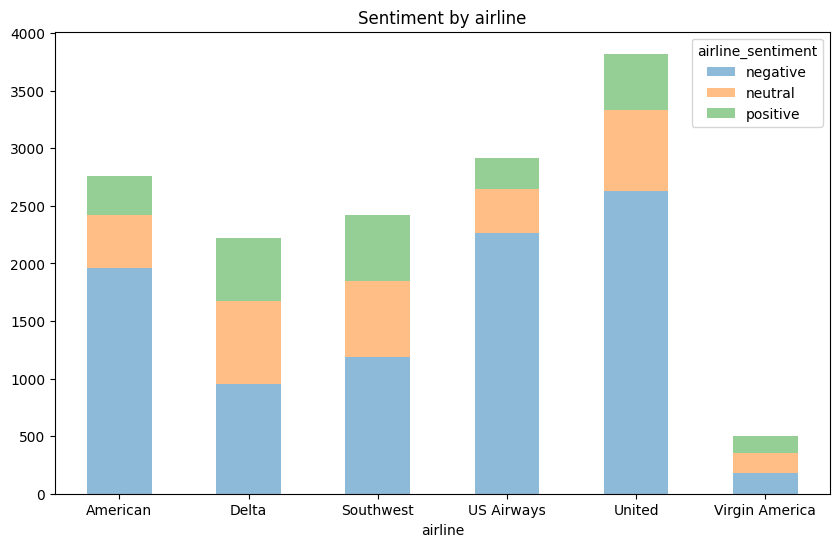

In [6]:
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiment by airline")

# Exercise 1.1

Predict the sentiment using CountVectorizer

use Random Forest classifier

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [8]:
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [9]:
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
from prettytable import PrettyTable

random_state = 42
size_test = 0.2

def print_metrics(origin_test, pred_test):
    """
    Prints classification metrics.

    Args:
        origin_test: The true labels.
        pred_test: The predicted labels.
    """

    metrics = {
        'Accuracy': accuracy_score(origin_test, pred_test),
        'Recall': recall_score(origin_test, pred_test, average='macro'),
        'F1-score': f1_score(origin_test, pred_test, average='macro'),
        'Phi coefficient': matthews_corrcoef(origin_test, pred_test)
    }

    print('')
    print('The results of the adjustment metrics:')
    print('')
    
    for metric, value in metrics.items():
        print(f"      {metric}: {value:.3f}")

    return metrics


def comparar_tamaños_vocabularios(*tamaños):
    """
    Compara los tamaños de múltiples vocabularios y devuelve un DataFrame.

    Args:
        *tamaños: Tamaños de los vocabularios.

    Returns:
        DataFrame con los tamaños comparados.
    """

    data = {'Diccionario': [f'Diccionario {i+1}' for i in range(len(tamaños))],
            'Tamaño': tamaños}
    df = pd.DataFrame(data)

    table = PrettyTable()
    table.field_names = df.columns.tolist()
    for index, row in df.iterrows():
        table.add_row(row.values.tolist())

    return table


def comparar_metricas(*args, **kwargs):
    """
    Compara múltiples diccionarios de métricas y devuelve un DataFrame.

    Args:
        *args: Diccionarios de métricas.
        **kwargs:
            index_name: Nombre de la columna del índice (por defecto 'metrica').

    Returns:
        DataFrame con las métricas comparadas.
    """

    dfs = []
    index_name = kwargs.get('index_name', 'metrica')

    for i, metric_dict in enumerate(args):
        df = pd.DataFrame.from_dict(metric_dict, orient='index', columns=[f'modelo_{i+1}'])
        df[f'modelo_{i+1}'] = round(df[f'modelo_{i+1}'], 3)
        df.index.name = index_name
        dfs.append(df)

    df_comparacion = pd.concat(dfs, axis=1).reset_index()

    table = PrettyTable()
    table.field_names = df_comparacion.columns.tolist()
    for index, row in df_comparacion.iterrows():
        table.add_row(row.values.tolist())

    return table

In [10]:
# Convertir X en un dataframe
# ==============================================================================
print(type(X))

df_x = X.to_frame()
df_x = df_x.reset_index()
df_x.head()

<class 'pandas.core.series.Series'>


,tweet_id,text
0,570306133677760513,@VirginAmerica What @dhepburn said.
1,570301130888122368,@VirginAmerica plus you've added commercials t...
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,@VirginAmerica and it's a really big bad thing...


In [11]:
# Creamos un CountVectorizer y transformamos los tweets
# ==============================================================================
count_vect = CountVectorizer()
X1 = count_vect.fit_transform(df_x['text'])

In [12]:
# Imprimir el vocabulario creado
# ==============================================================================
print(f"Our vocabulary: {count_vect.vocabulary_} ")

Our vocabulary: {'virginamerica': 14273, 'what': 14551, 'dhepburn': 4804, 'said': 11646, 'plus': 10438, 'you': 14944, 've': 14193, 'added': 1965, 'commercials': 4030, 'to': 13326, 'the': 13120, 'experience': 5665, 'tacky': 12925, 'didn': 4821, 'today': 13330, 'must': 9234, 'mean': 8837, 'need': 9375, 'take': 12941, 'another': 2331, 'trip': 13509, 'it': 7685, 'really': 11020, 'aggressive': 2054, 'blast': 3070, 'obnoxious': 9726, 'entertainment': 5455, 'in': 7381, 'your': 14953, 'guests': 6733, 'faces': 5740, 'amp': 2263, 'they': 13167, 'have': 6868, 'little': 8392, 'recourse': 11078, 'and': 2281, 'big': 3007, 'bad': 2746, 'thing': 13176, 'about': 1862, 'seriously': 11914, 'would': 14778, 'pay': 10175, '30': 761, 'flight': 6004, 'for': 6157, 'seats': 11832, 'that': 13115, 'this': 13188, 'playing': 10403, 'only': 9836, 'flying': 6101, 'va': 14145, 'yes': 14922, 'nearly': 9371, 'every': 5572, 'time': 13270, 'fly': 6086, 'vx': 14345, 'ear': 5238, 'worm': 14751, 'won': 14715, 'go': 6557, 'aw

In [13]:
# Imprimir longitud de vocabulario creado
# ==============================================================================
tamaño_diccionarito1 = len(count_vect.vocabulary_)
print(f'Vocabulary size: {tamaño_diccionarito1}')

Vocabulary size: 15051


In [14]:
# Guardamos un CSV con el diccionario creado
# ==============================================================================
# diccionarito = count_vect.vocabulary_
# df_diccionarito = pd.DataFrame.from_dict(diccionarito, orient='index', columns=['índice'])
# df_diccionarito = df_diccionarito.reset_index()
# df_diccionarito.rename(columns={'index':'word'}, inplace=True)
# df_diccionarito = df_diccionarito.sort_values(by=['índice'], ascending=True)
# df_diccionarito.to_csv('df_diccionarito.csv', encoding = 'utf-8-sig', index = False)
# df_diccionarito.head(5)

In [15]:
# Creamos un CountVectorizer y transformamos los tweets
# ==============================================================================
count_vect = CountVectorizer()
X1 = count_vect.fit_transform(df_x['text'])

In [16]:
# Imprimir el vocabulario creado
# ==============================================================================
print(f"Our vocabulary: {count_vect.vocabulary_} ")

Our vocabulary: {'virginamerica': 14273, 'what': 14551, 'dhepburn': 4804, 'said': 11646, 'plus': 10438, 'you': 14944, 've': 14193, 'added': 1965, 'commercials': 4030, 'to': 13326, 'the': 13120, 'experience': 5665, 'tacky': 12925, 'didn': 4821, 'today': 13330, 'must': 9234, 'mean': 8837, 'need': 9375, 'take': 12941, 'another': 2331, 'trip': 13509, 'it': 7685, 'really': 11020, 'aggressive': 2054, 'blast': 3070, 'obnoxious': 9726, 'entertainment': 5455, 'in': 7381, 'your': 14953, 'guests': 6733, 'faces': 5740, 'amp': 2263, 'they': 13167, 'have': 6868, 'little': 8392, 'recourse': 11078, 'and': 2281, 'big': 3007, 'bad': 2746, 'thing': 13176, 'about': 1862, 'seriously': 11914, 'would': 14778, 'pay': 10175, '30': 761, 'flight': 6004, 'for': 6157, 'seats': 11832, 'that': 13115, 'this': 13188, 'playing': 10403, 'only': 9836, 'flying': 6101, 'va': 14145, 'yes': 14922, 'nearly': 9371, 'every': 5572, 'time': 13270, 'fly': 6086, 'vx': 14345, 'ear': 5238, 'worm': 14751, 'won': 14715, 'go': 6557, 'aw

In [17]:
# Imprimir longitud de vocabulario creado
# ==============================================================================
print(f'Vocabulary size: {len(count_vect.vocabulary_)}')

Vocabulary size: 15051


In [18]:
# # Guardamos un CSV con el diccionario creado
# # ==============================================================================
# diccionarito = count_vect.vocabulary_
# df_diccionarito = pd.DataFrame.from_dict(diccionarito, orient='index', columns=['índice'])
# df_diccionarito = df_diccionarito.reset_index()
# df_diccionarito.rename(columns={'index':'word'}, inplace=True)
# df_diccionarito = df_diccionarito.sort_values(by=['índice'], ascending=True)
# df_diccionarito.to_csv('df_diccionarito.csv', encoding = 'utf-8-sig', index = False)
# df_diccionarito.head(5)

In [19]:
# Verificar tamaños
# ==============================================================================
print(f'Matrix size X: total tweets: {X1.shape[0]}, Vocabulary size: {X1.shape[1]}, airline_sentiment: {y.shape[0]}')

Matrix size X: total tweets: 14640, Vocabulary size: 15051, airline_sentiment: 14640


In [20]:
# Reparto de datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=size_test, random_state=random_state)

In [21]:
# Random Forest classifier
# ==============================================================================
rf_model_1 = RandomForestClassifier(random_state=random_state)
rf_model_1.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
y_pred = rf_model_1.predict(X_test)
model1_metrics = print_metrics(y_test, y_pred)


The results of the adjustment metrics:

      Accuracy: 0.775
      Recall: 0.617
      F1-score: 0.660
      Phi coefficient: 0.531


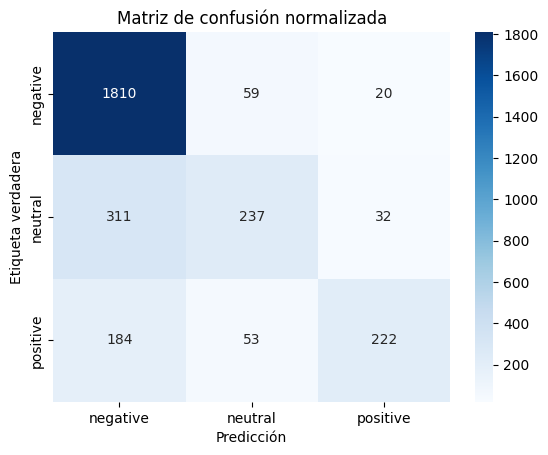

In [23]:
cm = confusion_matrix(y_test, y_pred)
class_labels = ["negative", "neutral", "positive"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')
plt.show()

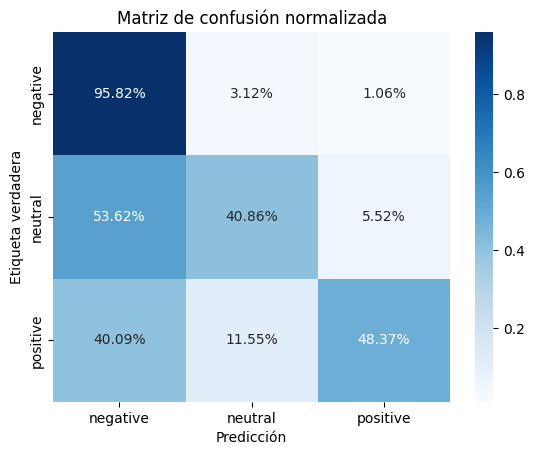

In [24]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
class_labels = ["negative", "neutral", "positive"]
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')
plt.show()

In [25]:
# # Guardamos un CSV para comparar los tweets antes, despues y las predicciones 
# # Esto no es valido
# # ==============================================================================
# df_salida = df_x.copy()
# df_salida['old_text'] = X.values
# df_salida = df_salida.loc[:,['tweet_id', 'old_text', 'text']]
# df_salida.rename(columns={'text':'new_text'}, inplace=True)
# df_salida['comparación'] = y.values 
# df_salida['predicción'] = rf_model_1.predict(X1)
# df_salida.to_csv('df_salida.csv', encoding = 'utf-8-sig', index = False)
# df_salida.head(5)

# Exercise 1.2

Remove stopwords, then predict the sentiment using CountVectorizer.

use Random Forest classifier

In [26]:
# Cargar las stopwords(english), cambiar esto si esta en otro idioma
# ==============================================================================
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [27]:
# Convertir X en un dataframe
# ==============================================================================
print(type(X))

df_x = X.to_frame()
df_x = df_x.reset_index()
df_x.head()

<class 'pandas.core.series.Series'>


,tweet_id,text
0,570306133677760513,@VirginAmerica What @dhepburn said.
1,570301130888122368,@VirginAmerica plus you've added commercials t...
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,@VirginAmerica and it's a really big bad thing...


In [28]:
# Retirar las stopwords
# ==============================================================================
df_x['text'] = df_x['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df_x.head()

,tweet_id,text
0,570306133677760513,@VirginAmerica What @dhepburn said.
1,570301130888122368,@VirginAmerica plus added commercials experien...
2,570301083672813571,@VirginAmerica I today... Must mean I need tak...
3,570301031407624196,@VirginAmerica really aggressive blast obnoxio...
4,570300817074462722,@VirginAmerica really big bad thing


In [29]:
# # Guardamos un CSV para comparar los tweets antes y despues de la transformación
# # ==============================================================================
# df_comparacion = df_x.copy()
# df_comparacion['old_text'] = X.values
# df_comparacion = df_comparacion.loc[:,['tweet_id', 'old_text', 'text']]
# df_comparacion.rename(columns={'text':'new_text'}, inplace=True)
# df_comparacion['comparación'] = y.values 
# df_comparacion.to_csv('df_comparacion.csv', encoding = 'utf-8-sig', index = False)
# df_comparacion.head(5)

In [30]:
# Creamos un CountVectorizer y transformamos los tweets
# ==============================================================================
count_vect = CountVectorizer()
X2 = count_vect.fit_transform(df_x['text'])

In [31]:
# Imprimir el vocabulario creado
# ==============================================================================
print(f"Our vocabulary: {count_vect.vocabulary_} ")

Our vocabulary: {'virginamerica': 14267, 'what': 14544, 'dhepburn': 4802, 'said': 11641, 'plus': 10433, 'added': 1964, 'commercials': 4028, 'experience': 5663, 'tacky': 12920, 'today': 13325, 'must': 9230, 'mean': 8833, 'need': 9371, 'take': 12936, 'another': 2329, 'trip': 13504, 'really': 11015, 'aggressive': 2052, 'blast': 3068, 'obnoxious': 9722, 'entertainment': 5453, 'guests': 6731, 'faces': 5738, 'amp': 2261, 'little': 8388, 'recourse': 11073, 'big': 3005, 'bad': 2744, 'thing': 13171, 'seriously': 11909, 'would': 14770, 'pay': 10170, '30': 761, 'flight': 6002, 'seats': 11827, 'playing': 10398, 'flying': 6099, 'va': 14139, 'yes': 14914, 'nearly': 9367, 'every': 5570, 'time': 13265, 'fly': 6084, 'vx': 14339, 'ear': 5236, 'worm': 14743, 'won': 14707, 'go': 6555, 'away': 2665, 'missed': 9039, 'prime': 10638, 'opportunity': 9865, 'men': 8898, 'without': 14676, 'hats': 6862, 'parody': 10099, 'there': 13145, 'https': 7184, 'co': 3942, 'mwpg7grezp': 9239, 'well': 14507, 'didn': 4819, 'bu

In [32]:
# Imprimir longitud de vocabulario creado
# ==============================================================================
tamaño_diccionarito2 = len(count_vect.vocabulary_)
print(f'Vocabulary size: {tamaño_diccionarito2}')

Vocabulary size: 15042


In [33]:
# # Guardamos un CSV con el diccionario creado
# # ==============================================================================
# diccionarito = count_vect.vocabulary_
# df_diccionarito = pd.DataFrame.from_dict(diccionarito, orient='index', columns=['índice'])
# df_diccionarito = df_diccionarito.reset_index()
# df_diccionarito.rename(columns={'index':'word'}, inplace=True)
# df_diccionarito = df_diccionarito.sort_values(by=['índice'], ascending=True)
# df_diccionarito.to_csv('df_diccionarito.csv', encoding = 'utf-8-sig', index = False)
# df_diccionarito.head(5)

In [34]:
# Verificar tamaños
# ==============================================================================
print(f'Matrix size X: total tweets: {X2.shape[0]}, Vocabulary size: {X2.shape[1]}, airline_sentiment: {y.shape[0]}')

Matrix size X: total tweets: 14640, Vocabulary size: 15042, airline_sentiment: 14640


In [35]:
# Reparto de datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=size_test, random_state=random_state)

In [36]:
# Random Forest classifier
# ==============================================================================
rf_model_2 = RandomForestClassifier(random_state=random_state)
rf_model_2.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [37]:
y_pred = rf_model_2.predict(X_test)
model2_metrics = print_metrics(y_test, y_pred)


The results of the adjustment metrics:

      Accuracy: 0.779
      Recall: 0.657
      F1-score: 0.686
      Phi coefficient: 0.548


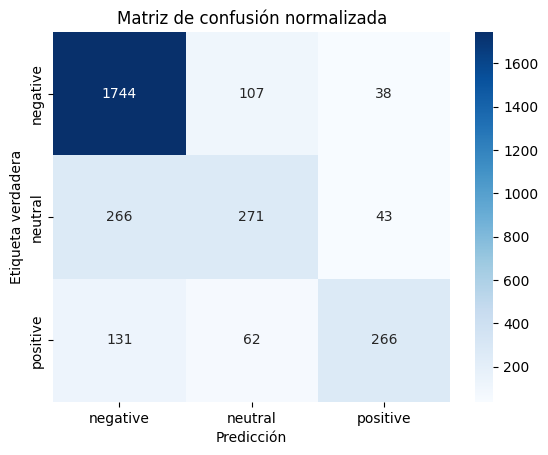

In [38]:
cm = confusion_matrix(y_test, y_pred)
class_labels = ["negative", "neutral", "positive"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')
plt.show()

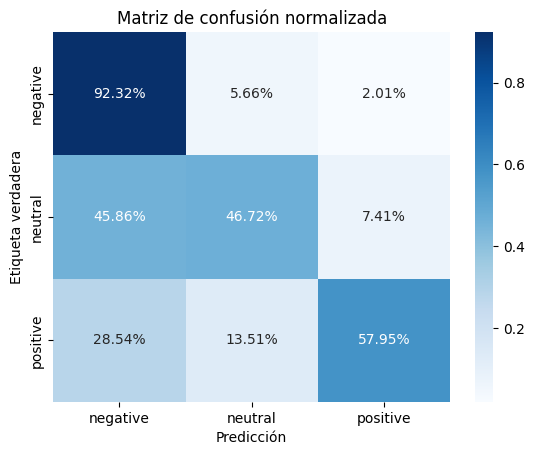

In [39]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
class_labels = ["negative", "neutral", "positive"]
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')
plt.show()

In [40]:
# # Guardamos un CSV para comparar los tweets antes, despues y las predicciones 
# # Esto no es valido
# # ==============================================================================
# df_salida = df_x.copy()
# df_salida['old_text'] = X.values
# df_salida = df_salida.loc[:,['tweet_id', 'old_text', 'text']]
# df_salida.rename(columns={'text':'new_text'}, inplace=True)
# df_salida['comparación'] = y.values 
# df_salida['predicción'] = rf_model_1.predict(X1)
# df_salida.to_csv('df_salida.csv', encoding = 'utf-8-sig', index = False)
# df_salida.head(5)

# Exercise 1.3

Increase n_grams size (with and without stopwords),  then predict the sentiment using CountVectorizer

use Random Forest classifier

# Exercise 1.4

Predict the sentiment using TfidfVectorizer.

use Random Forest classifier

# Resultados

In [41]:
df_comparacion = comparar_tamaños_vocabularios(tamaño_diccionarito1, tamaño_diccionarito2)
print(df_comparacion)

+---------------+--------+
|  Diccionario  | Tamaño |
+---------------+--------+
| Diccionario 1 | 15051  |
| Diccionario 2 | 15042  |
+---------------+--------+


In [42]:
df_comparacion = comparar_metricas(model1_metrics, model2_metrics, index_name='métrica')
print(df_comparacion)

+-----------------+----------+----------+
|     métrica     | modelo_1 | modelo_2 |
+-----------------+----------+----------+
|     Accuracy    |  0.775   |  0.779   |
|      Recall     |  0.617   |  0.657   |
|     F1-score    |   0.66   |  0.686   |
| Phi coefficient |  0.531   |  0.548   |
+-----------------+----------+----------+
